# Model Building

### Settings/Functions
Read in settings and functions.

In [51]:
libraries <-c('here','caret','Metrics','MLmetrics','randomForest'
              ,'caTools','rpart.plot','ROCR','MASS','RANN','regclass')
suppressWarnings(lapply(libraries, require, character.only = TRUE))
suppressWarnings(source(here::here('Stock Estimation', 'settings.R')))

[[1]]
[1] TRUE

[[2]]
[1] TRUE

[[3]]
[1] TRUE

[[4]]
[1] TRUE

[[5]]
[1] TRUE

[[6]]
[1] TRUE

[[7]]
[1] TRUE

[[8]]
[1] TRUE

[[9]]
[1] TRUE

[[10]]
[1] TRUE

[[11]]
[1] TRUE

## Data

 - The only data set needed for this stage of the analysis is the cleaned data. Although a mean imputed data set was created and exported to CSV in the last stage, I have decided to impute the missing values as part of a preprocess technique that will also scale my data set at the same time.

In [2]:
data <- fread(paste0(dir$final_data,'clean_financial.csv')) 

In [3]:
#Checking the proportions of my completed data set
complete <- na.omit(data)
is.data.frame(complete)

prop.table(table(complete$class))

complete <- complete[,-c('nextyr_price_var')]
complete$class <- as.factor(complete$class)
complete <- complete[, -c('stock','sector')]
#The proportions show that there are more "Buy" stocks (class = 1) than there are "Not Buy" stocks (class = 0) in the dataset

[1] TRUE


        0         1 
0.4374275 0.5625725 

In [4]:
#Determing how best to split the dataset
#Splitting 70/30
split <- sample.split(complete$class, SplitRatio = 0.70)
train <- subset(complete, split == TRUE)
test <- subset(complete, split == FALSE)

train %>%
  group_by(year, class) %>%
  summarise(n = n()) %>%
  mutate(freq = n / sum(n))

test %>%
  group_by(year, class) %>%
  summarise(n = n()) %>%
  mutate(freq = n / sum(n))

year,class,n,freq
<int>,<fct>,<int>,<dbl>
2014,0,671,0.6007162
2014,1,446,0.3992838
2015,0,410,0.2798635
2015,1,1055,0.7201365
2016,0,647,0.3566703
2016,1,1167,0.6433297
2017,0,1354,0.6897606
2017,1,609,0.3102394
2018,0,613,0.2935824


year,class,n,freq
<int>,<fct>,<int>,<dbl>
2014,0,280,0.5833333
2014,1,200,0.4166667
2015,0,192,0.2935780
2015,1,462,0.7064220
2016,0,268,0.3409669
2016,1,518,0.6590331
2017,0,586,0.7017964
2017,1,249,0.2982036
2018,0,257,0.2974537


In [5]:
dtree <- rpart(class ~ ., data = train, method = "class")
pred_dtree <- predict(dtree, test, type = "class")
confusionMatrix(pred_dtree, test$class, mode = "prec_recall")

Confusion Matrix and Statistics

          Reference
Prediction    0    1
         0 1118  733
         1  465 1303
                                          
               Accuracy : 0.669           
                 95% CI : (0.6534, 0.6843)
    No Information Rate : 0.5626          
    P-Value [Acc > NIR] : < 2.2e-16       
                                          
                  Kappa : 0.3398          
                                          
 Mcnemar's Test P-Value : 1.219e-14       
                                          
              Precision : 0.6040          
                 Recall : 0.7063          
                     F1 : 0.6511          
             Prevalence : 0.4374          
         Detection Rate : 0.3089          
   Detection Prevalence : 0.5115          
      Balanced Accuracy : 0.6731          
                                          
       'Positive' Class : 0               
                                          

In [6]:
importance <- varImp(dtree)
importance$names <- row.names(importance)
varlist <- importance[order(importance$Overall,decreasing = T),]
head(varlist, n = 5)

,Overall,names
,<dbl>,<chr>
year,591.34394,year
effect_of_forex_changes_on_cash,202.34956,effect_of_forex_changes_on_cash
earnings_yield,125.92059,earnings_yield
pe_ratio,104.43702,pe_ratio
consolidated_income,99.16256,consolidated_income


In [7]:
#Splitting by year 2018 vs all previous
train <- complete %>% filter(year != 2018)
test <- complete %>% filter(year == 2018)

train %>%
  group_by(year, class) %>%
  summarise(n = n()) %>%
  mutate(freq = n / sum(n))

test %>%
  group_by(year, class) %>%
  summarise(n = n()) %>%
  mutate(freq = n / sum(n))

year,class,n,freq
<int>,<fct>,<int>,<dbl>
2014,0,951,0.5954915
2014,1,646,0.4045085
2015,0,602,0.2840963
2015,1,1517,0.7159037
2016,0,915,0.3519231
2016,1,1685,0.6480769
2017,0,1940,0.6933524
2017,1,858,0.3066476


year,class,n,freq
<int>,<fct>,<int>,<dbl>
2018,0,870,0.2947154
2018,1,2082,0.7052846


In [8]:
dtree <- rpart(class ~ ., data = train, method = "class")
pred_dtree <- predict(dtree, test, type = "class")
confusionMatrix(pred_dtree, test$class, mode = "prec_recall")

Confusion Matrix and Statistics

          Reference
Prediction    0    1
         0  870 2082
         1    0    0
                                          
               Accuracy : 0.2947          
                 95% CI : (0.2783, 0.3115)
    No Information Rate : 0.7053          
    P-Value [Acc > NIR] : 1               
                                          
                  Kappa : 0               
                                          
 Mcnemar's Test P-Value : <2e-16          
                                          
              Precision : 0.2947          
                 Recall : 1.0000          
                     F1 : 0.4553          
             Prevalence : 0.2947          
         Detection Rate : 0.2947          
   Detection Prevalence : 1.0000          
      Balanced Accuracy : 0.5000          
                                          
       'Positive' Class : 0               
                                          

In [9]:
importance <- varImp(dtree)
importance$names <- row.names(importance)
varlist <- importance[order(importance$Overall,decreasing = T),]
head(varlist, n = 5)

,Overall,names
,<dbl>,<chr>
year,534.28946,year
earnings_per_share,251.22977,earnings_per_share
earnings_yield,245.78573,earnings_yield
capitalexpenditurecoverageratios,103.05688,capitalexpenditurecoverageratios
effect_of_forex_changes_on_cash,99.22573,effect_of_forex_changes_on_cash


## Data Splitting

 - Due to the high importance of the "year" variable, I believe it was best to remove the year variable from the dataset so that the model does not simply classify "class" primarily on the "year" variable.
 - Since stock performance can fluctuate substantially from year to year, I believe this will create a more accurate model.

In [10]:
#Removing year
complete <- complete[, -c('year')]

#Splitting the dataset into two and checking proportions
split <- sample.split(complete$class, SplitRatio = 0.70)
train <- subset(complete, split == TRUE)
test <- subset(complete, split == FALSE)

prop.table(table(train$class))
prop.table(table(test$class))

dim(train)
dim(test)


        0         1 
0.4374334 0.5625666 


        0         1 
0.4374137 0.5625863 

[1] 8447   94

[1] 3619   94

In [11]:
head(complete)

class,sector_num,cost_of_revenue,r.d_expenses,sg.a_expense,interest_expense,income_tax_expense,net_income__noncontrolling_int,net_income__discontinued_ops,preferred_dividends,...,payout_ratio,interest_coverage,dividend_yield,pe_ratio,pfcf_ratio,pocf_ratio,days_payables_outstanding,free_cash_flow_per_share,roe,ptb_ratio
<fct>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,...,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,4,11069350000,0.00e+00,3605470900,412660400,615708000,12000000,0.0,0,...,0.209,6.1242,0.0174,12.0340,14.6302,5.1147,18.1099,0.837,0.28210,7.09820
1,4,11069350000,0.00e+00,3605470900,412660400,615708000,26000000,0.0,0,...,0.753,20.2526,0.0289,26.0617,21.9662,17.4214,73.2730,1.922,0.23410,20.50659
0,4,11069350000,0.00e+00,3605470900,412660400,615708000,48035000,-1075700.0,0,...,0.384,11.3328,0.0252,15.2408,22.4610,10.3903,28.6724,3.920,0.21010,4.26270
1,4,3523600000,0.00e+00,1480500000,60400000,89100000,0,-1075700.0,0,...,0.482,8.7301,0.0173,27.8029,22.2716,16.2848,42.9625,1.710,0.20410,0.00000
1,4,5297000000,1.22e+08,1505000000,122000000,374000000,-747924,-1075700.0,0,...,0.452,11.1639,0.0296,15.3007,23.1014,14.7459,23.2650,2.191,0.53523,0.00000
0,4,11069350000,0.00e+00,3605470900,412660400,615708000,0,511145.9,0,...,0.510,4.2393,0.0285,17.8742,7.4811,5.3718,37.5605,4.637,0.12140,2.15890


## Baseline Model
Creating the baseline model.

 - I chose to test three different types of models to see which one would be the best. These models were logit, decision tree, and random forest. Using accuracy as a basic metric, the random forest model preformed the best and was thus used for further analysis.

## Baseline Logit Model

In [12]:
set.seed(123)
glm <- glm(class~., family = binomial(link = "logit")
           , data = train, control = list(maxit = 100))

#Model Accuracy
summary(glm)


Call:
glm(formula = class ~ ., family = binomial(link = "logit"), data = train, 
    control = list(maxit = 100))

Deviance Residuals: 
   Min      1Q  Median      3Q     Max  
-2.350  -1.179   0.752   1.025   2.078  

Coefficients:
                                                Estimate Std. Error z value
(Intercept)                                   -3.754e-01  1.701e-01  -2.208
sector_num                                     7.815e-02  9.479e-03   8.244
cost_of_revenue                                4.147e-13  1.996e-11   0.021
r.d_expenses                                  -6.904e-10  5.911e-10  -1.168
sg.a_expense                                  -6.158e-11  5.555e-11  -1.109
interest_expense                              -1.857e-10  5.815e-10  -0.319
income_tax_expense                             1.524e-10  2.939e-10   0.519
net_income__noncontrolling_int                -4.025e-09  2.699e-09  -1.491
net_income__discontinued_ops                   7.164e-08  8.580e-08   0.835
prefer

In [13]:
glm$aic

[1] 11043.07

In [14]:
pred_glm <- predict(glm, type = "response")

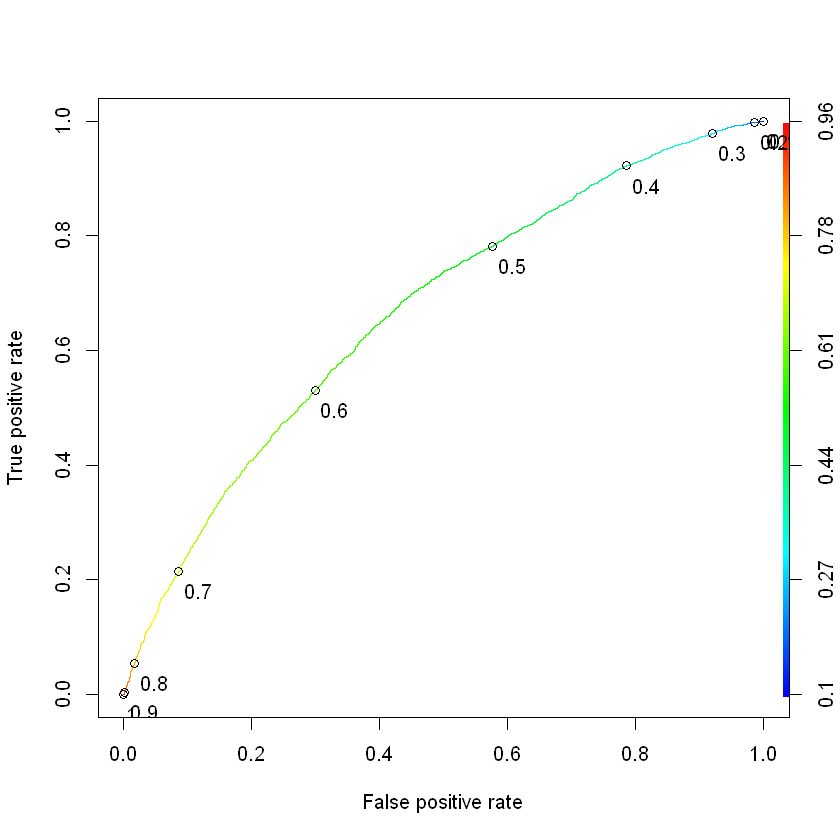

In [15]:
ROCRpred <- prediction(pred_glm, train$class)

ROCRperf <- ROCR::performance(ROCRpred, "tpr", "fpr")
plot(ROCRperf, colorize=TRUE, print.cutoffs.at=seq(0,1,by=0.1), text.adj=c(-0.2,1.7))

In [16]:
#Predicting and checking accuracy
predict_test <- predict(glm, type = "response", newdata = test)
summary(predict_test)
predict_test <- ifelse(predict_test >= 0.5, 1, 0)

Incorrect <- mean(predict_test != test$class)
print(paste("Accuracy of",1-Incorrect))

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
0.06241 0.47047 0.56962 0.55830 0.65466 0.92755 

[1] "Accuracy of 0.60099474993092"


In [17]:
set.seed(123)
importance <- varImp(glm)

In [18]:
print(importance)

                                                 Overall
sector_num                                    8.24400950
cost_of_revenue                               0.02078022
r.d_expenses                                  1.16799085
sg.a_expense                                  1.10859211
interest_expense                              0.31930360
income_tax_expense                            0.51869660
net_income__noncontrolling_int                1.49129667
net_income__discontinued_ops                  0.83501637
preferred_dividends                           1.26219817
earnings_per_share                            3.64554427
weighted_average_shs_out_dil                  0.18321868
dividend_per_share                            1.00072517
ebitda_margin                                 0.14820894
consolidated_income                           3.48827034
cash_and_cash_equivalents                     0.48196797
shortterm_investments                         2.68224813
receivables                    

## Baseline Decision Tree

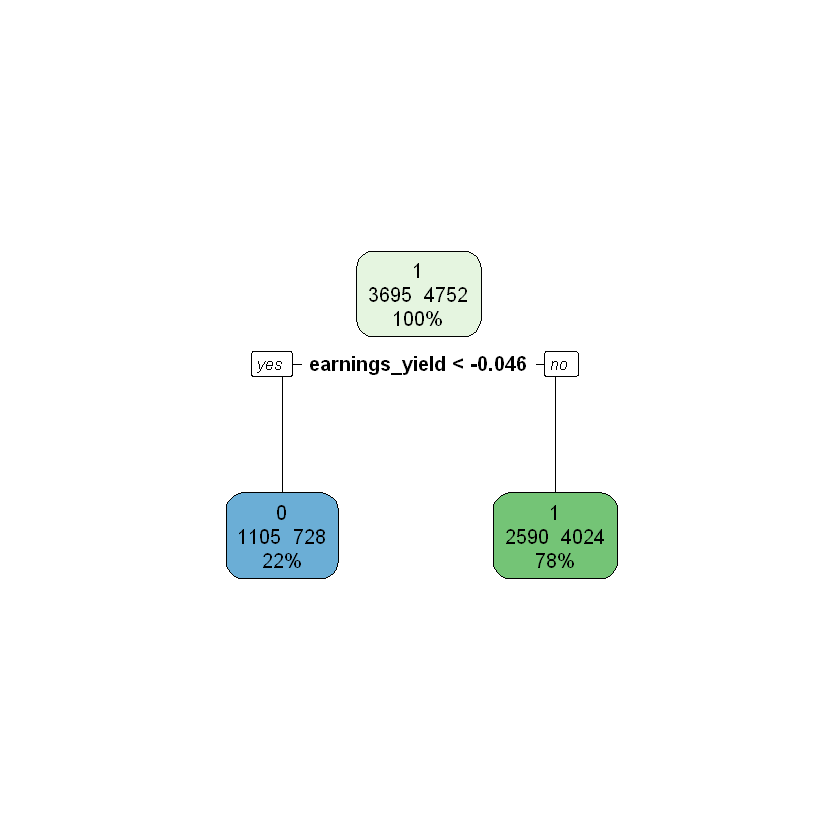

In [19]:
dtree <- rpart(class ~ ., data = train, method = "class")

rpart.plot(dtree, extra = 101)

In [20]:
pred_dtree <- predict(dtree, test, type = "class")

confusionMatrix(pred_dtree, test$class, mode = "prec_recall")

print(paste('AUC', auc(pred_dtree, test$class)))

Confusion Matrix and Statistics

          Reference
Prediction    0    1
         0  438  358
         1 1145 1678
                                          
               Accuracy : 0.5847          
                 95% CI : (0.5684, 0.6008)
    No Information Rate : 0.5626          
    P-Value [Acc > NIR] : 0.003808        
                                          
                  Kappa : 0.1068          
                                          
 Mcnemar's Test P-Value : < 2.2e-16       
                                          
              Precision : 0.5503          
                 Recall : 0.2767          
                     F1 : 0.3682          
             Prevalence : 0.4374          
         Detection Rate : 0.1210          
   Detection Prevalence : 0.2200          
      Balanced Accuracy : 0.5504          
                                          
       'Positive' Class : 0               
                                          

[1] "AUC 0.572327186766279"


## Baseline Random Forest

In [21]:
#Training using ‘random forest’ algorithm
set.seed(123)
forest <- randomForest(class ~ ., data = train, type = "classification")
#summary(forest)
forest


Call:
 randomForest(formula = class ~ ., data = train, type = "classification") 
               Type of random forest: classification
                     Number of trees: 500
No. of variables tried at each split: 9

        OOB estimate of  error rate: 37.61%
Confusion matrix:
     0    1 class.error
0 1707 1988   0.5380244
1 1189 3563   0.2502104

In [22]:
#Predicting on train set
pred_rf <- predict(forest, newdata = test[,-'class'])

confusionMatrix(pred_rf, test$class, mode = "prec_recall")

print(paste('AUC', auc(pred_rf, test$class)))

Confusion Matrix and Statistics

          Reference
Prediction    0    1
         0  743  532
         1  840 1504
                                          
               Accuracy : 0.6209          
                 95% CI : (0.6049, 0.6367)
    No Information Rate : 0.5626          
    P-Value [Acc > NIR] : 6.401e-13       
                                          
                  Kappa : 0.2127          
                                          
 Mcnemar's Test P-Value : < 2.2e-16       
                                          
              Precision : 0.5827          
                 Recall : 0.4694          
                     F1 : 0.5199          
             Prevalence : 0.4374          
         Detection Rate : 0.2053          
   Detection Prevalence : 0.3523          
      Balanced Accuracy : 0.6040          
                                          
       'Positive' Class : 0               
                                          

[1] "AUC 0.612191661647594"


In [23]:
baserf_results <- list(confusionMatrix(pred_rf, test$class, mode = "prec_recall")
                       , paste('AUC', auc(pred_rf, test$class)))

## Model Improvement
Improving on the baseline model. 

I have chosen to train a classification model. Given the non-normal distribution of the data, I need to either center the data to normalize it or choose a model that doesn't assume normal distribution. I have chosen random forest, which does not assume that the data has a normal distribution. The presence of missing data is also a potential issue, which is why I hvae decided to scale and impute missing data. In order to evaluate the performance of the model, I am primarily concerned with F1 and AUC since the dataset has a non-normal distribution.

### Scaling & Imputation

 - The dataset has vastly differing scales, so I decided to scale the data and impute missing values. I chose to use knn imputation over median imputation since knn imputation adds some variability to the missing values.

In [24]:
#NOTE: This portion of the code has been commented out since it takes a fair amount of time to run.
#Scaling and Knn Imputing Data Set
missing <- data[,-c('year','nextyr_price_var')]
missing$class <- as.factor(missing$class)
missing <- missing[, -c('stock', 'sector')]

imputedknn <- preProcess(missing[, -'class'], method = c("scale", "knnImpute"))

imputedknn <- predict(imputedknn, missing)
sum(is.na(imputedknn))
fwrite(imputedknn, paste0(dir$final_data, 'knn_financial.csv'))  

#imputedknn <- fread(paste0(dir$final_data, 'knn_financial.csv'))

[1] 0

In [25]:
imputedknn$class <- as.factor(imputedknn$class)
imputedknn$sector_num <- data$sector_num
imputedknn$year <- data$year
imputedknn$sector_num <- as.factor(imputedknn$sector_num)

#Splitting the dataset into two and checking proportions
set.seed(123)
split <- sample.split(imputedknn$class, SplitRatio = 0.70)
train <- subset(imputedknn, split == TRUE)
test <- subset(imputedknn, split == FALSE)

#Removing year from the test and train sets
train <- train[, -'year']
test <- test[, -'year']

prop.table(table(train$class))
prop.table(table(test$class))

dim(test)
dim(train)


        0         1 
0.4539886 0.5460114 


       0        1 
0.454066 0.545934 

[1] 5878   94

[1] 13714    94

In [26]:
#Running random forest model with knn imputation#
set.seed(123)
forestknn <- randomForest(class ~ ., data = train, type = "classification", importance = TRUE)
forestknn

#Predicting on train set
pred_knn <- predict(forestknn, newdata = test[, -'class']) 

confusionMatrix(pred_knn, test$class, mode = "prec_recall")

print(paste('AUC', auc(pred_knn, test$class)))


Call:
 randomForest(formula = class ~ ., data = train, type = "classification",      importance = TRUE) 
               Type of random forest: classification
                     Number of trees: 500
No. of variables tried at each split: 9

        OOB estimate of  error rate: 38.25%
Confusion matrix:
     0    1 class.error
0 3012 3214   0.5162223
1 2031 5457   0.2712340

Confusion Matrix and Statistics

          Reference
Prediction    0    1
         0 1291  789
         1 1378 2420
                                          
               Accuracy : 0.6313          
                 95% CI : (0.6189, 0.6437)
    No Information Rate : 0.5459          
    P-Value [Acc > NIR] : < 2.2e-16       
                                          
                  Kappa : 0.2423          
                                          
 Mcnemar's Test P-Value : < 2.2e-16       
                                          
              Precision : 0.6207          
                 Recall : 0.4837          
                     F1 : 0.5437          
             Prevalence : 0.4541          
         Detection Rate : 0.2196          
   Detection Prevalence : 0.3539          
      Balanced Accuracy : 0.6189          
                                          
       'Positive' Class : 0               
                                          

[1] "AUC 0.628925269372544"


### Feature Selection and Engineering

 - To determine whether all the variables are necessary, I looked at the importance of the variables from the random forest model. While the sector of the stock has the highest importance, none of the other variables really stand out. In addition, after using decision trees to look at each year and see how different they are, I feel that it is best to keep all the variables in the dataset. This is because the reduced dataset that took only those variables for each from the decision tree that had an importance greater than zero ended up performing worse than previous random forest models.

In [27]:
##Checking importance of variables from the knn imputed random forest##
importance(forestknn)

,0,1,MeanDecreaseAccuracy,MeanDecreaseGini
sector_num,7.72577958,16.4610398,21.243452,144.83382
cost_of_revenue,4.75511205,5.7823953,10.664696,59.31891
r.d_expenses,0.98527882,4.3622438,5.274755,39.68677
sg.a_expense,8.21166184,4.3374613,13.284011,84.46812
interest_expense,3.28889713,5.0855160,8.590693,54.28495
income_tax_expense,6.54799295,7.8275468,12.228063,79.50409
net_income__noncontrolling_int,5.39348367,-0.2929466,4.094481,36.12020
net_income__discontinued_ops,2.40238110,0.9930758,2.301021,15.09469
preferred_dividends,4.14875264,-0.5347619,2.648197,15.24566
earnings_per_share,10.57112908,7.9357611,17.276417,106.44910


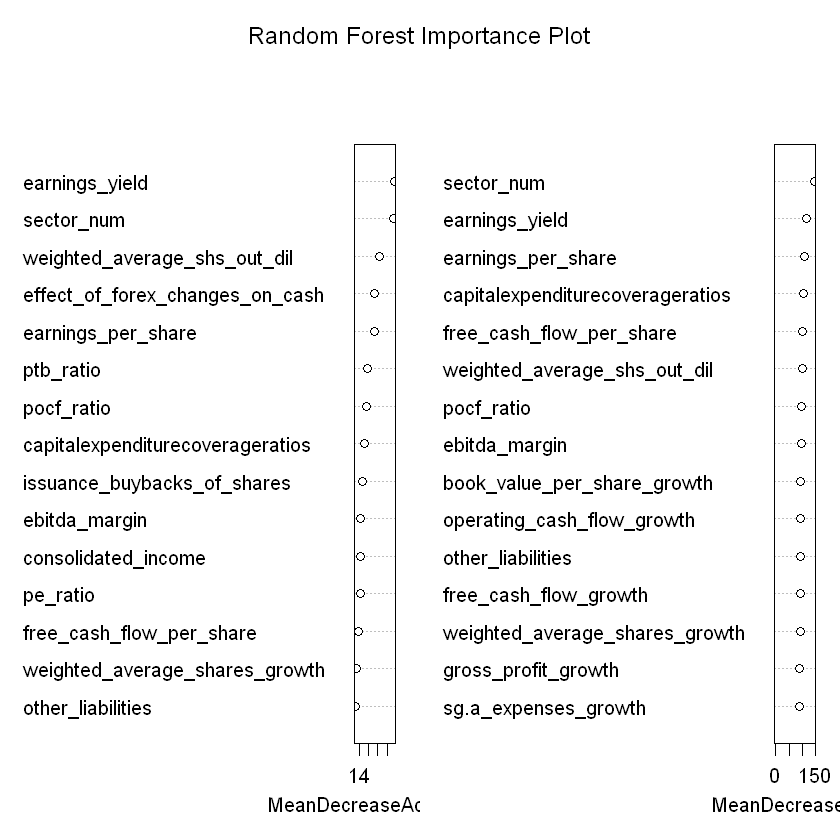

In [28]:
varImpPlot(forestknn, n.var = 15, main = "Random Forest Importance Plot")

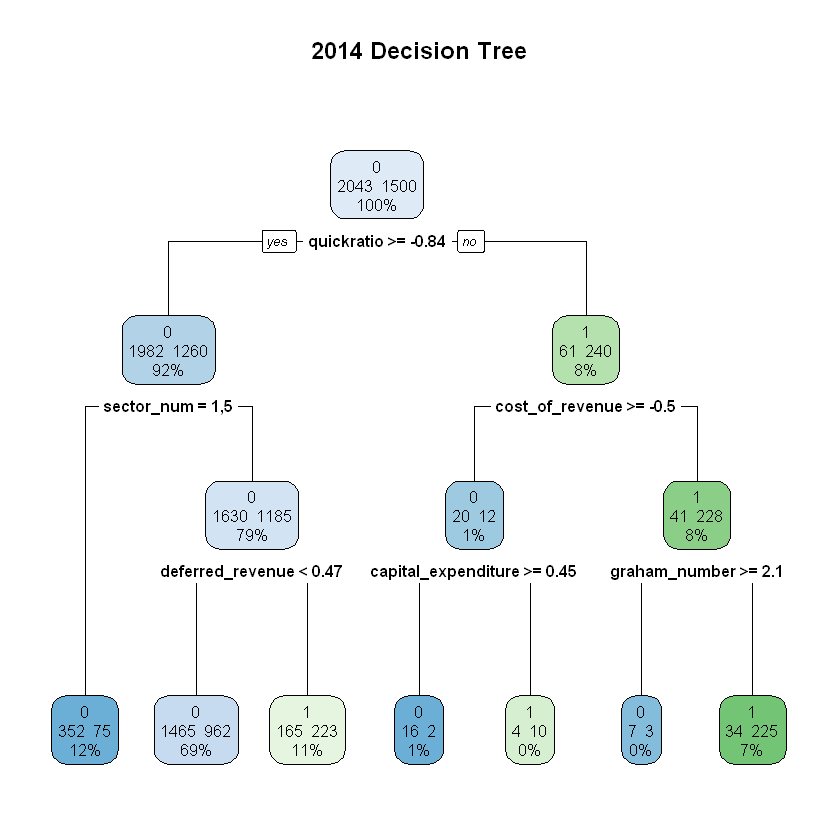

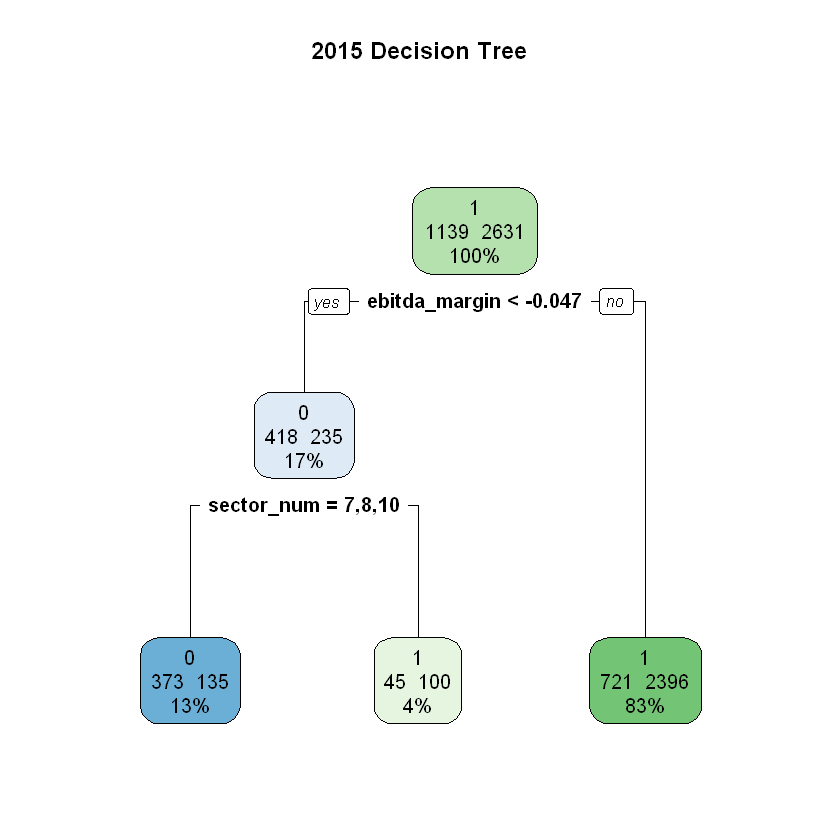

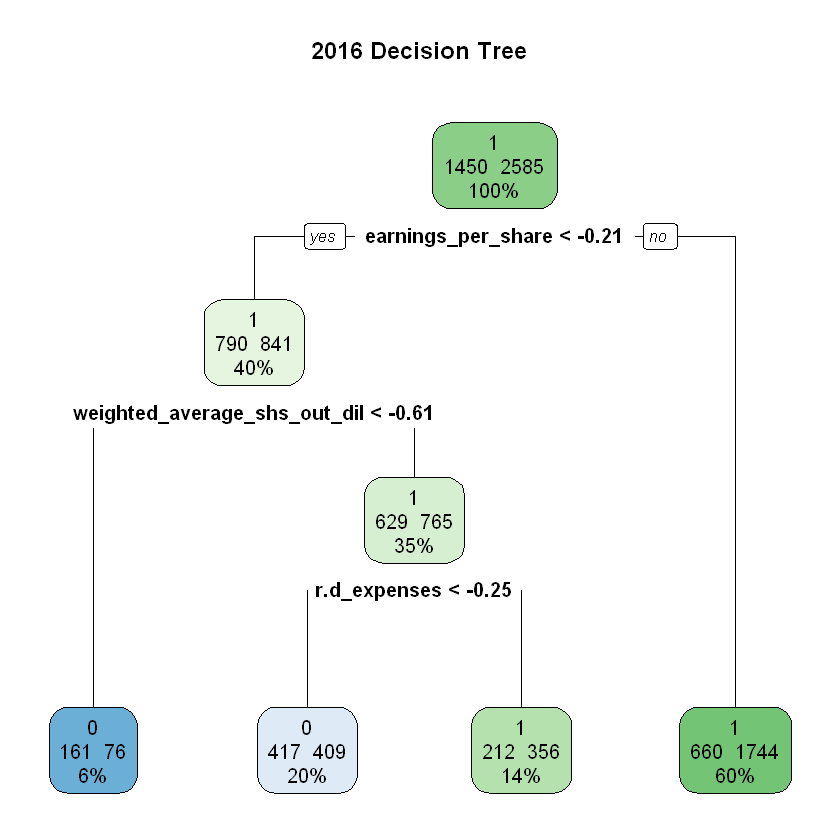

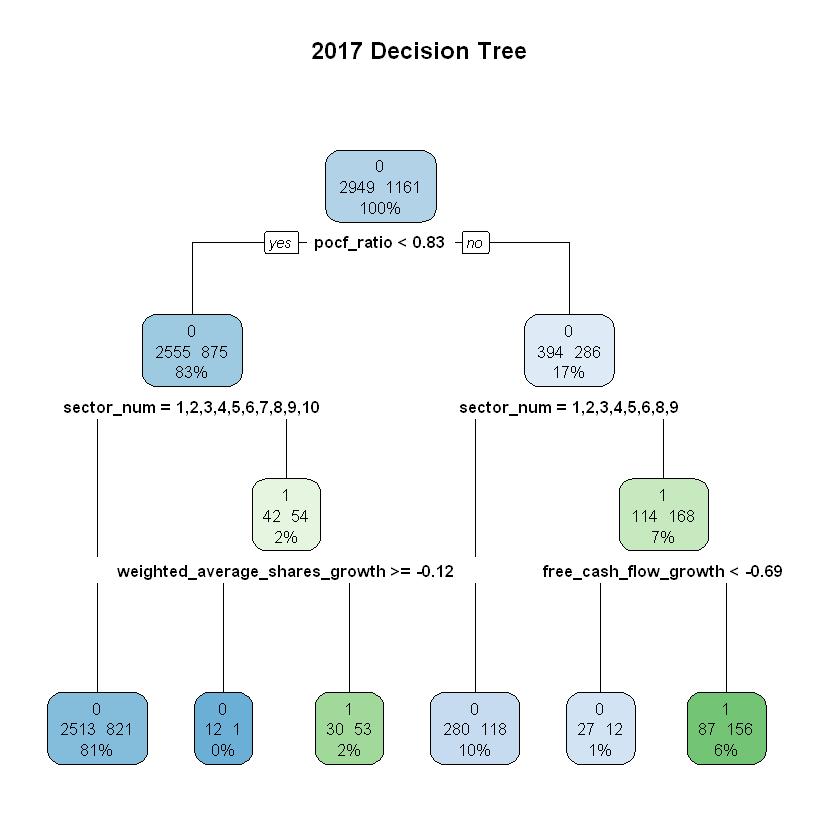

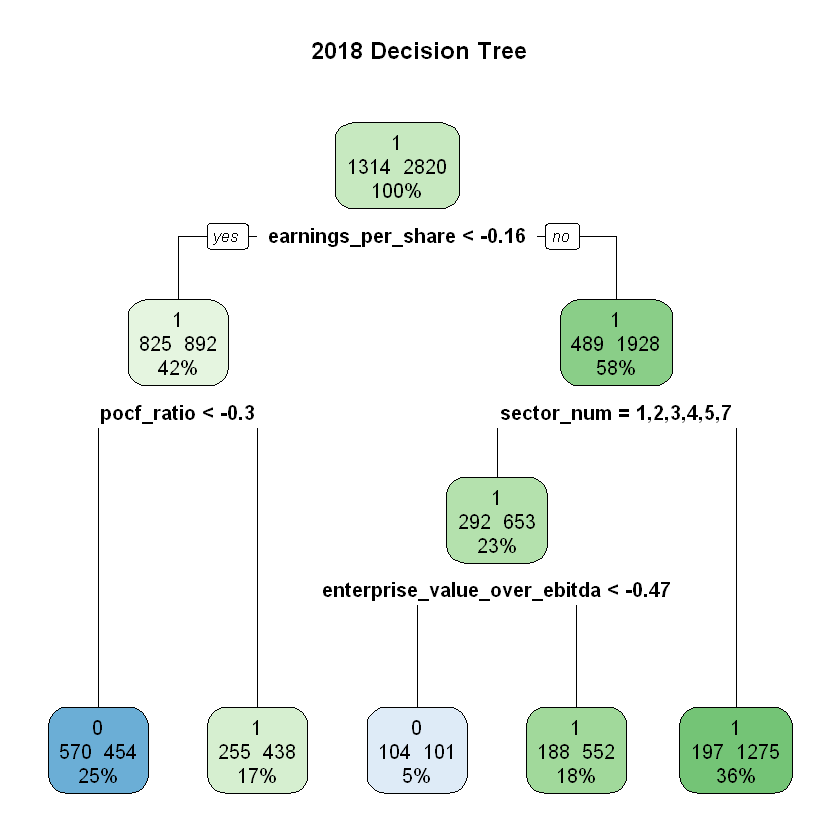

In [29]:
#Checking variable importance per year using decision trees to see if there are any trends across years#
dtree2014 <- DTree(dat=imputedknn,2014)
rpart.plot(dtree2014, extra = 101, roundint = FALSE, main = "2014 Decision Tree")
importance14 <- varImp(dtree2014)

dtree2015 <- DTree(dat=imputedknn,2015)
rpart.plot(dtree2015, extra = 101, roundint = FALSE, main = "2015 Decision Tree")
importance15 <- varImp(dtree2015)

dtree2016 <- DTree(dat=imputedknn,2016)
rpart.plot(dtree2016, extra = 101, roundint = FALSE, main = "2016 Decision Tree")
importance16 <- varImp(dtree2016)

dtree2017 <- DTree(dat=imputedknn,2017)
rpart.plot(dtree2017, extra = 101, roundint = FALSE, main = "2017 Decision Tree")
importance17 <- varImp(dtree2017)

dtree2018 <- DTree(dat=imputedknn,2018)
rpart.plot(dtree2018, extra = 101, roundint = FALSE, main = "2018 Decision Tree")
importance18 <- varImp(dtree2018)

In [30]:
importancematrix <- cbind(importance14, importance15, importance16, importance17, importance18)
head(importancematrix, n=25)

,Overall,Overall,Overall,Overall,Overall
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
capital_expenditure,5.730159,206.56445,92.979144,29.520749,28.96509
capitalexpenditurecoverageratios,106.962287,180.46060,85.246580,6.942308,151.26350
cash_and_cash_equivalents,5.292909,156.93088,9.035321,36.143454,19.82532
consolidated_income,4.665954,28.55062,105.268850,10.814052,22.29471
cost_of_revenue,12.773889,27.09978,72.986365,21.592084,22.12876
currentratio,80.899583,189.68039,69.744831,15.553511,155.35822
deferred_revenue,48.502286,220.11666,28.651895,7.336793,146.54359
earnings_per_share,17.305882,0.00000,25.072924,4.539019,133.53522
ev_to_free_cash_flow,21.347923,0.00000,7.897998,4.580937,42.79437


In [31]:
#Reducing the variables to only those that show an importance of greater than 0
importance14$names <- row.names(importance14)
importance14 <- importance14[which(importance14$Overall > 0), ]

importance15$names <- row.names(importance15)
importance15 <- importance15[which(importance15$Overall > 0), ]

importance16$names <- row.names(importance16)
importance16 <- importance16[which(importance16$Overall > 0), ]

importance17$names <- row.names(importance17)
importance17 <- importance17[which(importance17$Overall > 0), ]

importance18$names <- row.names(importance18)
importance18 <- importance18[which(importance18$Overall > 0), ]

In [32]:
#Combining each year's important variables, removing duplicates, and using their names to create a reduced dataset
names <- rbind(importance14, importance15, importance16, importance17, importance18)
names <- distinct(names, names, .keep_all= TRUE)
variables <- as.vector(names$names)

reduced_train <- train[, names(train) %in% c('class',variables), with=FALSE] 
reduced_test <- test[,  names(train) %in% c('class',variables), with=FALSE] 

is.data.frame(reduced_train)
is.data.frame(reduced_test)

dim(reduced_train)
dim(reduced_test)

[1] TRUE

[1] TRUE

[1] 13714    49

[1] 5878   49

In [33]:
#Running random forest model with reduced data set
set.seed(123)
reducedforest <- randomForest(class ~ ., data = reduced_train, type = "classification", importance = TRUE)
reducedforest
#Predicting on train set
pred_red <- predict(reducedforest, newdata = reduced_test[, -'class']) 

confusionMatrix(pred_red, reduced_test$class, mode = "prec_recall")

print(paste('AUC', auc(pred_red, reduced_test$class)))


Call:
 randomForest(formula = class ~ ., data = reduced_train, type = "classification",      importance = TRUE) 
               Type of random forest: classification
                     Number of trees: 500
No. of variables tried at each split: 6

        OOB estimate of  error rate: 39.85%
Confusion matrix:
     0    1 class.error
0 2891 3335   0.5356569
1 2130 5358   0.2844551

Confusion Matrix and Statistics

          Reference
Prediction    0    1
         0 1289  843
         1 1380 2366
                                          
               Accuracy : 0.6218          
                 95% CI : (0.6093, 0.6342)
    No Information Rate : 0.5459          
    P-Value [Acc > NIR] : < 2.2e-16       
                                          
                  Kappa : 0.224           
                                          
 Mcnemar's Test P-Value : < 2.2e-16       
                                          
              Precision : 0.6046          
                 Recall : 0.4830          
                     F1 : 0.5370          
             Prevalence : 0.4541          
         Detection Rate : 0.2193          
   Detection Prevalence : 0.3627          
      Balanced Accuracy : 0.6101          
                                          
       'Positive' Class : 0               
                                          

[1] "AUC 0.618101835203329"


### Hyperparameter Tuning

 - Here I decided to try to tune the random forest model by finding the best mtry value for the model. After it was found, I added it into the model and re-ran the random forest which improved my scores slightly.

mtry = 9  OOB error = 38.19% 
Searching left ...
mtry = 6 	OOB error = 38.33% 
-0.00381898 0.01 
Searching right ...
mtry = 13 	OOB error = 38.29% 
-0.002673286 0.01 
       mtry  OOBError
6.OOB     6 0.3833309
9.OOB     9 0.3818725
13.OOB   13 0.3828934


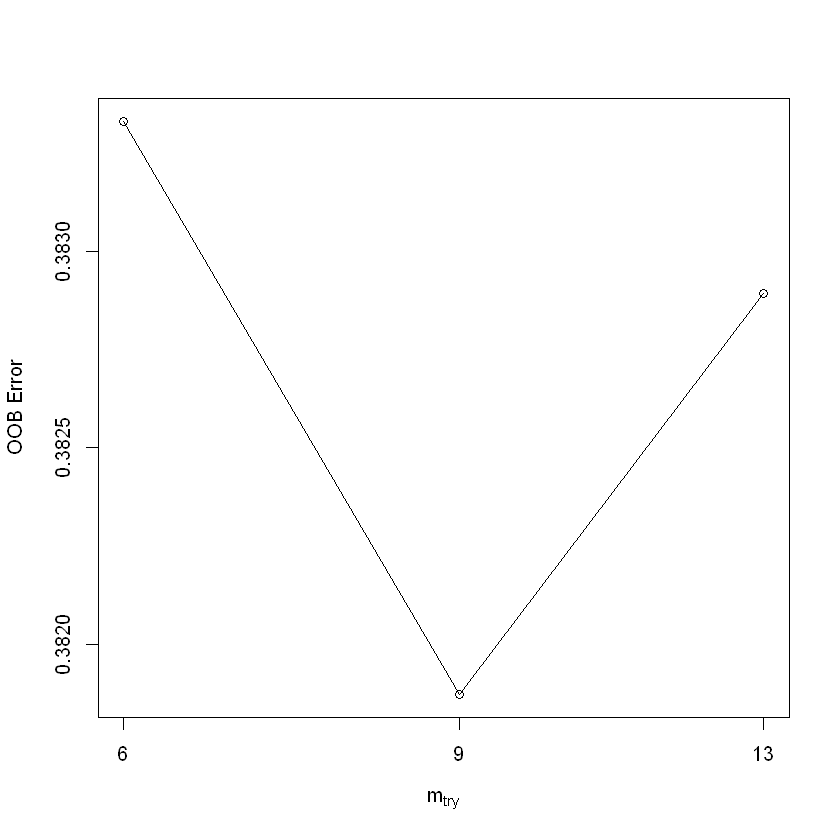

In [34]:
#Random Forest Tuning
#Finding best mtry
set.seed(123)
bestmtry <- tuneRF(train[, -'class'],train$class, ntreeTry=500,
                   stepFactor=1.5,improve=0.01, trace=TRUE, plot=TRUE)
print(bestmtry)

In [35]:
set.seed(123)
best.m <-bestmtry[bestmtry[, 2] == min(bestmtry[, 2]), 1]
print(best.m)

[1] 9


In [36]:
set.seed(123)
forest2 <- randomForest(class ~ ., data = train, ntree=500, mtry = best.m)
forest2


Call:
 randomForest(formula = class ~ ., data = train, ntree = 500,      mtry = best.m) 
               Type of random forest: classification
                     Number of trees: 500
No. of variables tried at each split: 9

        OOB estimate of  error rate: 38.19%
Confusion matrix:
     0    1 class.error
0 3033 3193   0.5128493
1 2044 5444   0.2729701

In [37]:
pred1 <- predict(forest2, newdata = test[,-'class']) 
confusionMatrix(pred1, test$class, mode = "prec_recall")
print(paste('AUC', auc(pred1, test$class)))

Confusion Matrix and Statistics

          Reference
Prediction    0    1
         0 1295  785
         1 1374 2424
                                         
               Accuracy : 0.6327         
                 95% CI : (0.6202, 0.645)
    No Information Rate : 0.5459         
    P-Value [Acc > NIR] : < 2.2e-16      
                                         
                  Kappa : 0.2451         
                                         
 Mcnemar's Test P-Value : < 2.2e-16      
                                         
              Precision : 0.6226         
                 Recall : 0.4852         
                     F1 : 0.5454         
             Prevalence : 0.4541         
         Detection Rate : 0.2203         
   Detection Prevalence : 0.3539         
      Balanced Accuracy : 0.6203         
                                         
       'Positive' Class : 0              
                                         

[1] "AUC 0.630413400777737"


### Additional Tuning, Processing, or Model-Improvement

 - Since the mtry value did not increase my scores that much, I decided to look at different ntree values to see if I could find a better match for the model. The ntree value of 500 from the previous random forest ended up returning better scores, so I decided to stick with it. Finally, I used a repeated cross validation model with the ntree value of 500 to finalize the model. This provided the highest scores yet.

In [38]:
control <- trainControl(method="repeatedcv", repeats = 2, number=2, search="random")

In [39]:
#NOTE: This portion of the code takes a fair amount of time to run.
#Checking for the best ntree value
modellist <- list()
for (ntree in c(1000, 1500, 2000, 2500)) {
    set.seed(123)
    fit <- train(class~., data=train, method="rf", trControl=control, ntree=ntree)
    key <- toString(ntree)
    modellist[[key]] <- fit
}


Call:
summary.resamples(object = results)

Models: 1000, 1500, 2000, 2500 
Number of resamples: 4 

Accuracy 
          Min.   1st Qu.    Median      Mean   3rd Qu.      Max. NA's
1000 0.6120753 0.6167785 0.6213359 0.6208619 0.6254193 0.6287006    0
1500 0.6094502 0.6183098 0.6249089 0.6221015 0.6287006 0.6291381    0
2000 0.6090127 0.6169972 0.6230859 0.6208619 0.6269506 0.6282631    0
2500 0.6095960 0.6194400 0.6249818 0.6217734 0.6273152 0.6275339    0

Kappa 
          Min.   1st Qu.    Median      Mean   3rd Qu.      Max. NA's
1000 0.2049120 0.2129497 0.2232899 0.2225255 0.2328656 0.2386102    0
1500 0.1993995 0.2166465 0.2304686 0.2252066 0.2390287 0.2404897    0
2000 0.1986129 0.2139312 0.2265281 0.2226545 0.2352514 0.2389487    0
2500 0.1998526 0.2190695 0.2306946 0.2246168 0.2362419 0.2372254    0


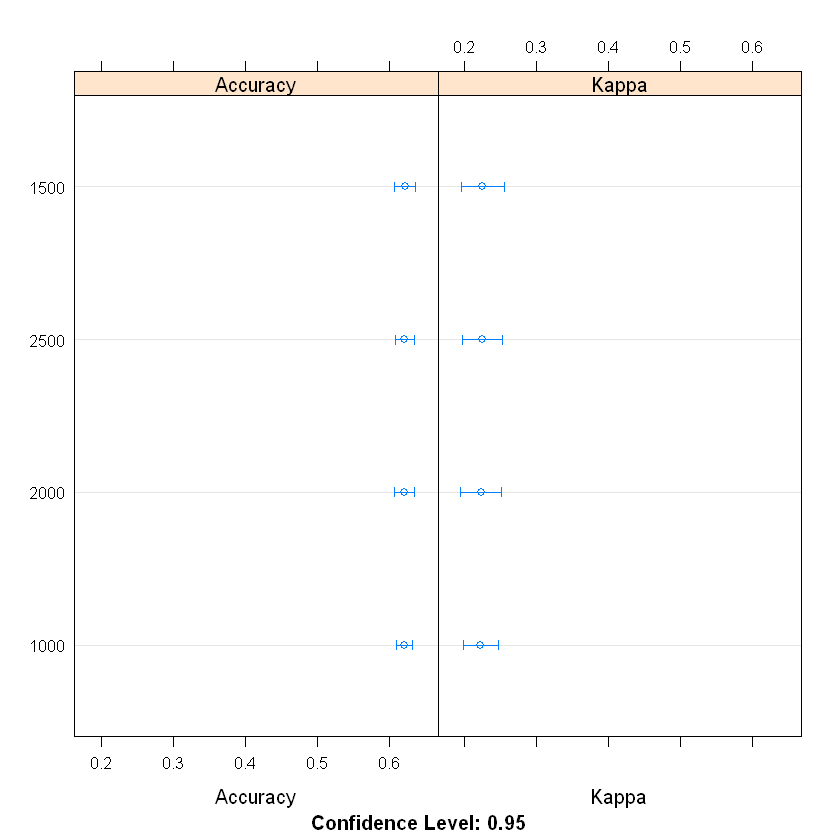

In [40]:
#Compare results
results <- resamples(modellist)
summary(results)
dotplot(results)

In [41]:
#Selecting the best "ntree" value and using repeated cross validation
ntree=500
control <- trainControl(method="repeatedcv", repeats = 2, number=2, search="random")

In [42]:
#NOTE: This portion of the code takes a long time to run.
#Using controls and cross validation
set.seed(123)
fit.rf <- train(class~., data=train, method="rf", ntree = ntree, maximize=TRUE)
fit.rf

Random Forest 

13714 samples
   93 predictor
    2 classes: '0', '1' 

No pre-processing
Resampling: Bootstrapped (25 reps) 
Summary of sample sizes: 13714, 13714, 13714, 13714, 13714, 13714, ... 
Resampling results across tuning parameters:

  mtry  Accuracy   Kappa    
    2   0.6099087  0.1976361
   52   0.6180208  0.2187676
  102   0.6172097  0.2172999

Accuracy was used to select the optimal model using the largest value.
The final value used for the model was mtry = 52.

In [43]:
pred_rf1 <- predict(fit.rf, newdata = test[, -'class']) 
confusionMatrix(pred_rf1, test$class, mode = "prec_recall")
print(paste('AUC', auc(pred_rf1, test$class)))

Confusion Matrix and Statistics

          Reference
Prediction    0    1
         0 1342  814
         1 1327 2395
                                          
               Accuracy : 0.6358          
                 95% CI : (0.6233, 0.6481)
    No Information Rate : 0.5459          
    P-Value [Acc > NIR] : < 2.2e-16       
                                          
                  Kappa : 0.2532          
                                          
 Mcnemar's Test P-Value : < 2.2e-16       
                                          
              Precision : 0.6224          
                 Recall : 0.5028          
                     F1 : 0.5563          
             Prevalence : 0.4541          
         Detection Rate : 0.2283          
   Detection Prevalence : 0.3668          
      Balanced Accuracy : 0.6246          
                                          
       'Positive' Class : 0               
                                          

[1] "AUC 0.632960115803441"


In [44]:
finalrf_results <- list(confusionMatrix(pred_rf1, test$class, mode = "prec_recall")
                        , paste('AUC', auc(pred_rf1, test$class)))

In [45]:
#Comparing Baseline RF Model vs Final RF Model
print(paste("Baseline Random Forest"))
baserf_results 

print(paste("Final Random Forest"))
finalrf_results 

[1] "Baseline Random Forest"


[[1]]
Confusion Matrix and Statistics

          Reference
Prediction    0    1
         0  743  532
         1  840 1504
                                          
               Accuracy : 0.6209          
                 95% CI : (0.6049, 0.6367)
    No Information Rate : 0.5626          
    P-Value [Acc > NIR] : 6.401e-13       
                                          
                  Kappa : 0.2127          
                                          
 Mcnemar's Test P-Value : < 2.2e-16       
                                          
              Precision : 0.5827          
                 Recall : 0.4694          
                     F1 : 0.5199          
             Prevalence : 0.4374          
         Detection Rate : 0.2053          
   Detection Prevalence : 0.3523          
      Balanced Accuracy : 0.6040          
                                          
       'Positive' Class : 0               
                                          

[[2]]
[1] "AUC 0.

[1] "Final Random Forest"


[[1]]
Confusion Matrix and Statistics

          Reference
Prediction    0    1
         0 1342  814
         1 1327 2395
                                          
               Accuracy : 0.6358          
                 95% CI : (0.6233, 0.6481)
    No Information Rate : 0.5459          
    P-Value [Acc > NIR] : < 2.2e-16       
                                          
                  Kappa : 0.2532          
                                          
 Mcnemar's Test P-Value : < 2.2e-16       
                                          
              Precision : 0.6224          
                 Recall : 0.5028          
                     F1 : 0.5563          
             Prevalence : 0.4541          
         Detection Rate : 0.2283          
   Detection Prevalence : 0.3668          
      Balanced Accuracy : 0.6246          
                                          
       'Positive' Class : 0               
                                          

[[2]]
[1] "AUC 0.

## Outcome
Explaining what steps were taken to train this model and why.

 1. Splitting the Data Set: I chose to split the data set 70/30 without the 'year' variable. This was because the high importance that the decision trees were putting on the year variable. I did not want the model to simply classify based on 'year' since this would cause the the model to be inaccurate in future years. In addition, when I looked at the possibly of splitting the data pre-2018 vs 2018, the proportions of the year 2018 were significantly different than the combined proportions for the previous four years. 
 2. Baseline Model: I chose the random forest model after looking at three different baseline models. It was the best performing model of the three.
 3. Scaling/Imputation: I chose to scale the data set since variables were vastly different. In addition, due to the large amount of missing data I decided to use imputation. I contemplated using median imputation but ended up choosing the knn imputation due to the variability it added to the data set vs using only the median.
 4. Tuning: I chose to tune my random forest model to find the best mtry value and used this value to re-run a random forest model. Due to only a slightly increase in metric scores, I decided to then look at expanding the grid to various other ntree values. I found, however, that the best ntree was the original value of 500. I then decided to finish the model with a cross-validation random forest since I had time to let the model take its time in running. This model, with the appropriate ntree of 500, came back with the highest scoring metrics and thus became my final model.
 - Overall: The model ended up improving by the following: </br>
     Baseline: ACC - .621 , F1 - .520 , AUC - .612 </br>
     Final: ACC - .636 , F1 - .556 , AUC - .633 </br>
     While this was not a substantial increase, the F1 score did improve by a fair amount. Originally, when I left the 'year' variable in the model, I was able to increase the ACC to over .669 and the F1 to .651. However, I believe that the models were mainly using the 'year' variable to do this. Had an additional year been added, the model would have performed poorly, as was seen in the beginning of this notebook when I split the data set pre-2018 vs 2018 and came back with an ACC of .295 and F1 of .455. In the end, I believe this model is best suited to return consistent results on future years.